In [1]:
from typing import List
from tests import generate_dataframe
import matplotlib.pyplot as plt
from functools import reduce
from typing import List
import pandas as pd
from matplotlib.colors import TABLEAU_COLORS

In [2]:
def histogram_width(indices: List[int], bar_width : float, increase : float) -> float:
    total_width = bar_width * indices[-1]
    for i, indices_len in enumerate(indices[:-1]):
        total_width = total_width * indices_len + (indices_len - 1) * (bar_width * (increase**(i+1)))
    return total_width

In [3]:
def bar_offset(bar_index: int, indices: List[int], bar_width: float, increase: float) -> float:
    x = bar_index * bar_width
    previous_bars = 1
    for j, index in enumerate(reversed(indices)):
        previous_bars *= index
        if bar_index >= previous_bars:
            x += (bar_index // previous_bars) * bar_width * (increase)
    return x

In [4]:
feature = "Feature 3"
df = generate_dataframe()[[feature]]

In [5]:
height = 5
bar_width = 0.3
increase = 1.01

In [6]:
indices = [len(x) for x in df.index.levels]

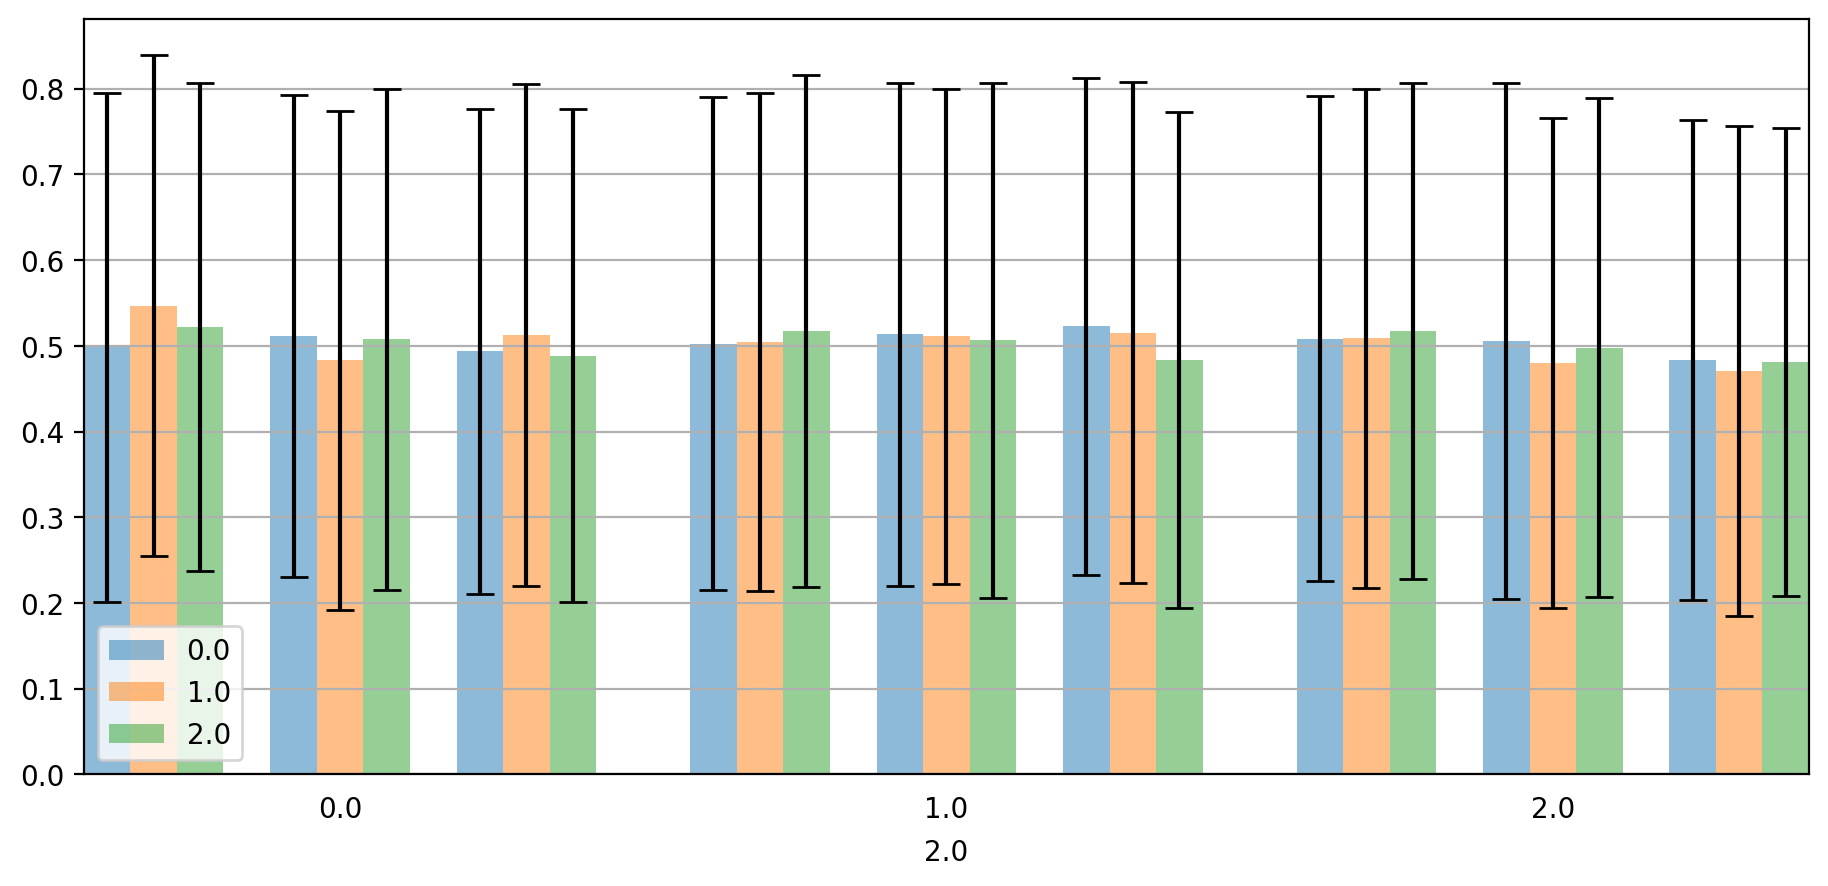

In [15]:
colors = list(TABLEAU_COLORS.keys())
prod = reduce(lambda x,y: x*y, indices)-1
width = bar_offset(prod, indices, bar_width, increase) + bar_width
fig, axis = plt.subplots(figsize=(
    width,
    height
), dpi=200)

labels_offsets = []
for i, (names, (mean, std)) in enumerate(df[feature].iterrows()):
    x = bar_offset(i, indices, bar_width, increase) + bar_width/2
    axis.bar(
        x,
        mean, 
        **({"yerr":std} if std>0 else {}),
        color=colors[list(df.index.levels[-1]).index(names[-1])],
        width = 0.3,
        alpha=0.5,
        capsize=5,
        label=names[-1]
    )
    previous_bars = indices[-1]
    
    for j, index in enumerate(reversed(indices[:-1])):
        previous_bars *= index
        if (i+1) % previous_bars == 0 and i!=0:
            if j == len(labels_offsets):
                labels_offsets.append(x/2)
            axis.text(
                x - labels_offsets[j] + bar_width/4,
                -j/20-0.05, 
                names[j],
                horizontalalignment='center'
            )
axis.yaxis.grid(True, which="both")
#fig.tight_layout()
axis.set_xlim(0, width)
axis.set_xticks([])
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axis.legend(by_label.values(), by_label.keys(), loc='best')